# Astar Consulting - LangGraph Workshop
<div style="text-align:center">
    <img src="./images/Astar Consulting.png" alt="levels of automation" width='80%'>
</div>

Welcome to the LangGraph Workshop! This workshop is designed to help you understand the basic concepts of building LLM applications with a focus on the LangGraph library.

**Astar Consulting:**
- [Website](https://www.astarconsulting.no/)
- [LinkedIn](https://www.linkedin.com/company/astarconsulting)

- [Erik Nymo Bohne](https://www.linkedin.com/in/erik-nymo-bohne-25868321a/)
- [Mikael Steenbuch](https://www.linkedin.com/in/mikael-steenbuch/)

## Sources

- [Langchain](https://python.langchain.com/v0.2/docs/introduction/)🦜
- [Langgraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/)🕸️
- [Langsmith](https://docs.smith.langchain.com/)🛠️

## Levels of automation - Motivation
The rapid development in large language models and frameworks has made it possible to automate a wide range of tasks. The levels of automation can be seen as a scale of how much human intervention is needed to complete a task. The scale ranges from 1 to 6, where 1 is no automation and 6 is full automation. With LangGraph we are designing systems to achieve level 4 and 5, and even reacing level 6 in some cases.
<div style="text-align:center">
    <img src="./images/LevelsOfAutomation.png" alt="levels of automation" width='80%'>
</div>

### Install the required packages

In [ ]:
%pip install -U langgraph langsmith langchain_openai langchain_community

### Set environment variables

In [10]:
import os

os.environ["LANGCHAIN_API_KEY"] = "your_key"
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

os.environ["OPENAI_API_KEY"] = "sk-keUrFilXq-v8soqanKzZWKjmeTRIcfFNuNNRQOney1T3BlbkFJfXcKvwluG426stbMGLL0ADmobqOWS2atbDth4VqjIA"

### 1. The State of the graph
The first thing you do when you define a graph is define the `State` of the graph. The `State` consists of the schema of the graph as well as `reducer functions` which specify how to apply updates to the state. The schema of the `State` will be the input schema to all `Nodes` and `Edges` in the graph, and can be either a `TypedDict` or a `Pydantic` model. All `Nodes` will emit updates to the `State` which are then applied using the specified reducer function.

Source: [Langchain AI - State of the graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)


In [12]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

### 2. Nodes for the graph
In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).

Source: [Langchain AI - Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)

In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model_name="gpt-4o-mini",
)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}

In [14]:
message = ("human", "Hva er hovedstaden i Norge?")
chatbot({"messages": [message]})

{'messages': [AIMessage(content='Hovedstaden i Norge er Oslo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 15, 'total_tokens': 24}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5bd87c427a', 'finish_reason': 'stop', 'logprobs': None}, id='run-837ecb9a-1ec0-43d5-9c1c-40e8b8c8748a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 9, 'total_tokens': 24})]}

### 3. Edges - The workflow of the graph
Edges define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- **Normal Edges**: Go directly from one node to the next.
- **Conditional Edges**: Call a function to determine which node(s) to go to next.
- **Entry Point**: Which node to call first when user input arrives.
- **Conditional Entry Point**: Call a function to determine which node(s) to call first when user input arrives.

A node can have **MULTIPLE** outgoing edges. If a node has multiple out-going edges, **all** of those destination nodes will be executed in parallel as a part of the next superstep.

Source: [Langchain AI - Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)

In [15]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

graph = workflow.compile()


### Lets take a look at our graph

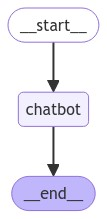

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke/stream the graph
LangGraph is built with first class support for streaming. There are several different ways to stream back results from the graph.

Source: [Langchain AI - Streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)

In [17]:
while True:
    user_input = input("User: ")
    print("User: " + user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Hei på deg
Assistant: Hei! Hvordan kan jeg hjelpe deg i dag?
User: Det går fint du da?
Assistant: Ja, det går fint! Takk for at du spør. Hvordan har du det?
User: 1
Assistant: Hello! It looks like you entered "1." How can I assist you today?
User: q
Goodbye!


### 4. Lets add tools to the graph

It's extremely common to want agents to do tool calling. Tool calling refers to choosing from several available tools, and specifying which ones to call and what the inputs should be. This is extremely common in agents, as you often want to let the LLM decide which tools to call and then call those tools.

Source: [Langchain AI - Tools](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling)

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]

In [19]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

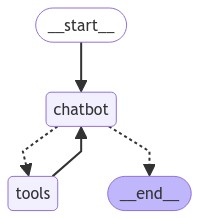

In [20]:
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", ToolNode(tools))

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("tools", "chatbot")

# Defining conditional edges
workflow.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  Hva er fyllingsgraden på norwegianflyene i august
Assistant: 
Assistant: [{"url": "https://media.no.norwegian.com/documents/traffic-report-august-2023-dot-pdf-434472", "content": "Norwegian med 2,1 millioner passasjerer i august . Norwegian hadde 2,1 millioner passasjerer og en fyllingsgrad p\u00e5 85,2 prosent i august. Regulariteten var spesielt h\u00f8y, og 99,6 prosent av oppsatte flyvninger ble gjennomf\u00f8rt. ... I 2023 hadde Norwegian over 20 millioner passasjerer og en fl\u00e5te p\u00e5 87 Boeing 737-800 og 737 MAX 8-fly."}, {"url": "https://media.no.norwegian.com/pressreleases/norwegian-med-21-millioner-passasjerer-i-august-3271222", "content": "Norwegian hadde 2,1 millioner passasjerer og en fyllingsgrad p\u00e5 85,2 prosent i august. Regulariteten var spesielt h\u00f8y, og 99,6 prosent av oppsatte flyvninger ble gjennomf\u00f8rt. ... I 2023 hadde Norwegian over 20 millioner passasjerer og en fl\u00e5te p\u00e5 87 Boeing 737-800 og 737 MAX 8-fly. Wider\u00f8es Flyve

## TASK 1: CREATE YOUR OWN TOOL

#### Suggestions:

**Easy:**
1. Create a tool that performs a simple mathematical operation (e.g. addition, matrix multiplication, etc.)

**Medium:**
1. Create a tool that performs a simple data analysis operation (e.g. Pandas.DataFrame.describe())

**Hard:**
1. Create a tool that writes and executes python code.

<br>

**Example tool:**
```python
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b
```

#### Documentation:
- [Langchain AI - Tools](https://python.langchain.com/v0.2/docs/how_to/tool_calling/)

In [ ]:
from langchain_core.tools import tool
from typing import Annotated


@tool
#-----------TASK 1: Write your own tool--------------
def my_tool():
    """Your tool description here"""
    pass
#-----------------------------------------------------

tools = [my_tool]

In [ ]:

llm_with_your_tool = llm.bind_tools(tools)

def chatbot_with_your_tool(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_your_tool.invoke(state["messages"])]}

workflow = StateGraph(GraphState)

workflow.add_node("chatbot_with_your_tool", chatbot_with_your_tool)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "chatbot_with_your_tool")
workflow.add_edge("tools", "chatbot_with_your_tool")

workflow.add_conditional_edges(
    "chatbot_with_your_tool",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = input("User: ")
for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

### Congratulations🎉 You have now created your first tool.

# Structured output

It's pretty common to want LLMs inside nodes to return structured output when building agents. This is because that structured output can often be used to route to the next step (e.g. choose between two different edges) or update specific keys of the state.

Source: [Langchain AI - Structured output](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#structured-output)

A structured output for weather might look like this:
```json
{
  "temperature": 25,
  "humidity": 0.5,
  "wind_speed": 10,
  "wind_direction": "N"
}


In [23]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List


class ResumeSummary(BaseModel):
    name: str = Field(..., title="Name if the applicant")
    experience: List[str] = Field(..., title="List of experiences")
    skills: List[str] = Field(..., title="List of skills")

Using the LangChain `.with_structured_output()` method, we can specify the output format of the tool. This will allow us to generate structured output from the tool.

In [24]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
    {application}
    """
)
chain = prompt | llm.with_structured_output(ResumeSummary)

Lets load some applications and test the structured output.

In [25]:

applications = []
folder_path = os.path.join("data", "applications")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            applications.append(file.read())

for application in applications:
    print(application)
    print(chain.invoke(application).json(indent=2))
    print("\n")


Hi! I’m Emily Davis and I’ve been a Senior Data Scientist for 8 years, mostly in the e-commerce sector. My main strengths are deep learning and data visualization. I’ve also worked with Python and TensorFlow extensively. I completed a PhD in Machine Learning and my last project was a demand prediction model that helped reduce stockouts by 20%. I’m looking to branch out into other industries, and I think this role is the perfect opportunity to apply my skills in new and challenging ways.
{
  "name": "Emily Davis",
  "experience": [
    "8 years as a Senior Data Scientist in the e-commerce sector",
    "Completed a PhD in Machine Learning",
    "Developed a demand prediction model that reduced stockouts by 20%"
  ],
  "skills": [
    "Deep Learning",
    "Data Visualization",
    "Python",
    "TensorFlow"
  ]
}


Hello, I’m David Lee, I’ve been working in data science for about 5 years now, mainly focusing on natural language processing (NLP). I have hands-on experience with Python, PyT

## Task 2: **Create a Structured Output from Unstructured Emails**

You are provided with 5 `.txt` files, each containing an email about an office supply order. The emails may include:

- Product names, quantities
- Delivery dates, addresses
- Customer details (names, contacts)

Your task is to create a structured object that captures the relevant data (e.g., products, quantities, delivery info) while handling potential noise and inconsistencies. The structure should be designed for future analysis and flexibility to deal with incomplete or messy information.

### Example Output:
```json
{
    "customer": {
        "name": "John Doe", 
        "company": "ACME Corp"
    },
    "order_items": [
        {
            "product": "Pens",
            "quantity": 10
        }
    ],
    "delivery": {
        "address": "123 Main St",
        "date": "2023-09-12"
    }
}
```

#### Documentation:

- [Langchain AI - Structured Output](https://python.langchain.com/v0.2/docs/how_to/structured_output/)


In [ ]:
orders = []
folder_path = os.path.join("data", "orders")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            orders.append(file.read())

# See how one of the orders look
print(orders[0])

You job now is to create the Pydantic object that will be used to structure the information in the emails.

In [ ]:
#-----------TASK 2: Write your pydantic object --------------
class Order(BaseModel):
    pass
#------------------------------------------------------------

In [ ]:
prompt = PromptTemplate(
    template="""
    {order}
    """
)
chain = prompt | llm.with_structured_output(Order)

In [ ]:
orders[0]
print(chain.invoke(orders[0]).json(indent=2))

# Basic Reflection

<div style="text-align:center">
    <img src="./images/Reflection.png" alt="basic agent reflection" width='50%'>
</div>


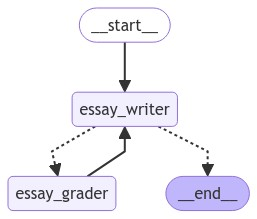

In [61]:
from langchain_core.output_parsers import StrOutputParser

llm_gpt_3_5 = ChatOpenAI(
    model_name="gpt-3.5-turbo",
)

class GraphState(TypedDict):
    essay: str
    feedback: Annotated[list, add_messages]

def essay_writer(state: GraphState):
    """Node that generate a 3 paragraph essay"""
    print("\n---ESSAY WRITER---")
    essay = state["essay"] if "essay" in state else "No essay yet"
    prompt = PromptTemplate(
        template="""
        Write a 3 paragraph essay based on the following feedback:

        Essay: {essay}

        Update the essay based on the feedback:

        Feedback: {feedback}
        """
    )
    generate = prompt | llm_gpt_3_5 | StrOutputParser()
    essay = generate.invoke({"essay": essay, "feedback": state["feedback"]})
    print("\nEssay: ", essay)
    return {"essay": [essay]}


def essay_grader(state: GraphState):
    """Node that grades an essay"""
    print("\n---ESSAY GRADER---")
    prompt = PromptTemplate(
        template="""
        You are a teacher grading an essay. Provide clear and consise feedback on how to improve the essay:

        Essay: {essay}
        """
    )
    generate = prompt | llm
    feedback = generate.invoke({"essay": state["essay"] if "essay" in state else "No essay yet"})
    print("\nFeedback: ", feedback)
    return {"feedback": [feedback]}


def should_continue(state: GraphState):
    """Node that checks if the user wants to continue"""
    print("\n---SHOULD CONTINUE---")
    if len(state["feedback"]) > 3:
        return "__end__"
    else:
        return "essay_grader"


workflow = StateGraph(GraphState)

workflow.add_node("essay_writer", essay_writer)
workflow.add_node("essay_grader", essay_grader)

workflow.add_edge(START, "essay_writer")
workflow.add_edge("essay_grader", "essay_writer")

workflow.add_conditional_edges(
    "essay_writer",
    should_continue
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
request = "Skriv en saktekst om Norges Teknisk-Naturvitenskapelige Universitet i Trondheim."

essay = graph.invoke({"feedback": [request]})
print("Essay: ", essay["essay"])


---ESSAY WRITER---

Essay:  Norges Teknisk-Naturvitenskapelige Universitet, also known as the Norwegian University of Science and Technology (NTNU) in Trondheim, is a prestigious institution known for its excellence in technical and natural sciences. Located in the heart of Norway, NTNU boasts a rich history of academic achievement and innovation in various fields of study. The university is renowned for its cutting-edge research facilities and world-class faculty members who are experts in their respective fields.

NTNU offers a wide range of undergraduate and graduate programs in engineering, science, technology, and natural sciences. Students at NTNU have access to state-of-the-art laboratories, research centers, and resources that enable them to engage in hands-on learning experiences and conduct groundbreaking research. The university's commitment to academic excellence and innovation has earned it a strong reputation both nationally and internationally, attracting students and r

## Task 3: **Create a code-generating agent with self reflection**

### Motivation
Code generation and analysis are two of most important applications of LLMs, as shown by the ubiquity of products like GitHub co-pilot and popularity of projects like GPT-engineer. The recent AlphaCodium work showed that code generation can be improved by using a flow paradigm rather than a naive prompt:answer paradigm: answers can be iteratively constructed by (1) testing answers and (2) reflecting on the results of these tests in order to improve the solution.

### Task
Create an agent that generates code based on what the user wants. Take a look at this flow diagram:

<div style="text-align:left">
    <img src="./images/Code-Generation.png" alt="basic agent reflection" width='50%'>
</div>

You are free to choose the complexity of the task with these suggestions:
1. Code execution: Create a tool that executes the code generated by the agent.
2. Documentation: Create a tool that retrieves the documentation of a given library.
3. Add support for multiple programming languages.


In [63]:
#-----------TASK 3.1: Write the GraphState and potentially any pydantic objects--------------
class GeneratedCode(BaseModel):
    pass

class GraphState(TypedDict):
    pass

In [ ]:
#-----------TASK 3.2: Define any tools that you may use--------------
@tool
def my_tool():
    pass

In [ ]:
#-----------TASK 3.3: Write the nodes--------------

In [ ]:
workflow = StateGraph(GraphState)

#-----------TASK 3.4: Define the workflow--------------


#-----------------------------------------------------

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### Now its time to see if the agent will work🤩

In [ ]:
request = input("What do you want to generate? ")
generated_code = graph.invoke({"request": request})
print("Generated Code: ", generated_code)

## This is the end of the workshop. We hope you enjoyed it.🎉